## Nickhil Tekwani || CS6220 || HW 3a

### PROBLEM 1: Supervised Classification Libraries: Regression, Decision Tree

In [ ]:
from sklearn.datasets import fetch_openml, fetch_20newsgroups
import pandas as pd

# Load MNIST
mnist = fetch_openml('mnist_784')

In [6]:
# Load 20NG
ng20 = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

In [10]:
spambase = pd.read_csv('./spambase/spambase.data', header=None, delimiter=',')
spambase_data = spambase.iloc[:, :-1]  # All columns except the last one (features)
spambase_target = spambase.iloc[:, -1]  # The last column (label)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# MNIST
mnist_data = StandardScaler().fit_transform(mnist.data)
mnist_target = mnist.target

# 20NG
vectorizer = TfidfVectorizer(max_features=5000)
ng20_data = vectorizer.fit_transform(ng20.data).toarray()


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

datasets = {
    'MNIST': (mnist_data, mnist_target),
    'Spambase': (spambase_data, spambase_target),
    '20NG': (ng20_data, ng20.target)
}

results = {}

for name, (data, target) in datasets.items():
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=42)
    
    # L2-reg Logistic Regression
    lr = LogisticRegression(penalty='l2', max_iter=5000).fit(X_train, y_train)
    lr_score = lr.score(X_test, y_test)
    
    # Decision Tree
    dt = DecisionTreeClassifier().fit(X_train, y_train)
    dt_score = dt.score(X_test, y_test)
    
    results[name] = {
        'Logistic Regression': (lr, lr_score),
        'Decision Tree': (dt, dt_score)
    }


In [14]:
import numpy as np

F = 30

for dataset, classifiers in results.items():
    for classifier, (model, score) in classifiers.items():
        print(f"Dataset: {dataset}, Classifier: {classifier}, Accuracy: {score:.4f}")
        
        if classifier == 'Logistic Regression':
            coef = model.coef_
            # Check if coef is 2D (multiple classes) or 1D (binary classification)
            if len(coef.shape) == 2:
                top_features = np.argsort(np.abs(coef), axis=1)[:, -F:]
            else:
                top_features = np.argsort(np.abs(coef))[-F:]
                top_features = [top_features]  # Make it a 2D list for consistent printing
            print("Top Features:", top_features)
        
        elif classifier == 'Decision Tree':
            importances = model.feature_importances_
            top_features = np.argsort(importances)[-F:]
            print("Top Features:", top_features)
        print('-'*60)


Dataset: MNIST, Classifier: Logistic Regression, Accuracy: 0.9165
Top Features: [[117 329 323 395 406 377 229 690 322 434 605 444 145 374 282 629 309 710
  461 684 367 240 712 207 402 408 517 339 544 379]
 [240 428 381 691 481 591 174 342 313 359 383  89 473 429 374 201 277 520
  537 467 137 332 455 300 565 439 472 510 465 314]
 [542 247 465 354 165 325 509 360  97 320 715 674 219 607 705 359 370 258
  193 340 283 425 316 343 136 318 248 306 305 368]
 [130 358 394 300 186 710 510 657 572 397 249 267 695 565 520 136 128 566
  445 330 164 767 303 332 501 359  92 276 304 360]
 [357 322 444 542 624 584 186 306 323 546 321 563 376 593  67 570 320 535
  636 379 360 554 595  91 495 565 544 442  97 676]
 [389 416 522 565 289 248 182 442 737 654 385 244 427 283 268 257 472 386
  116  96 444  91 304 414  70 311 328 332 330 360]
 [640 387 360 543 203 631 606 503 301 313 267 593 270 621 323 340 567 269
  178 681 516 299 355 712 622 682 651 713 683 691]
 [539 564 639 349 752 328 459 418 569 120 266

### PROBLEM 2 : PCA library on MNIST


In [15]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

def pca_and_classify(name, data, target, D):
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=42)

    # PCA with D features
    pca = PCA(n_components=D)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    classifiers = {
        'Logistic Regression': LogisticRegression(penalty='l2', max_iter=5000),
        'Decision Tree': DecisionTreeClassifier()
    }

    scores = {}

    for clf_name, clf in classifiers.items():
        clf.fit(X_train_pca, y_train)
        y_pred = clf.predict(X_test_pca)
        scores[clf_name] = accuracy_score(y_test, y_pred)

    return scores

# Problem 2 - A)
mnist_scores_5 = pca_and_classify('MNIST', mnist_data, mnist_target, 5)
mnist_scores_20 = pca_and_classify('MNIST', mnist_data, mnist_target, 20)
print(f"MNIST scores with D=5: {mnist_scores_5}")
print(f"MNIST scores with D=20: {mnist_scores_20}")

# Problem 2 - B)
def find_optimal_D_for_spambase():
    best_D = None
    original_scores = results['Spambase']

    for D in range(1, spambase_data.shape[1] + 1):  # Iterate from 1 to number of features
        pca_scores = pca_and_classify('Spambase', spambase_data, spambase_target, D)

        if all(abs(pca_scores[clf] - original_scores[clf][1]) < 0.01 for clf in pca_scores):
            best_D = D
            break

    return best_D, pca_scores

best_D, spambase_scores = find_optimal_D_for_spambase()
print(f"Optimal D for Spambase: {best_D}, with scores: {spambase_scores}")


MNIST scores with D=5: {'Logistic Regression': 0.6786285714285715, 'Decision Tree': 0.6704}
MNIST scores with D=20: {'Logistic Regression': 0.8684571428571428, 'Decision Tree': 0.8443428571428572}
Optimal D for Spambase: None, with scores: {'Logistic Regression': 0.9304952215464813, 'Decision Tree': 0.8592528236316247}


### PROBLEM 3 : Implement PCA on MNIST

In [17]:
import numpy as np

class CustomPCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.eigenvectors = None

    def fit_transform(self, X):
        # 1. Standardize the dataset
        X_standardized = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

        # 2. Compute the covariance matrix
        covariance_matrix = np.cov(X_standardized, rowvar=False)

        # 3. Compute the eigenvectors and eigenvalues
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

        # 4. Sort eigenvalues and eigenvectors in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        self.eigenvectors = eigenvectors[:, sorted_indices[:self.n_components]]

        # 5. Project the data onto the lower-dimensional subspace
        return np.dot(X_standardized, self.eigenvectors)

# Testing our CustomPCA on MNIST data for D=5 and D=20
D_values = [5, 20]
mnist_pca_results = {}

for D in D_values:
    pca = CustomPCA(n_components=D)
    mnist_data_pca = pca.fit_transform(mnist_data)

    # Handle NaNs
    mnist_data_pca = np.nan_to_num(mnist_data_pca)

    # Reuse the pca_and_classify function from previous code
    scores = pca_and_classify('MNIST', mnist_data_pca, mnist_target, D)
    mnist_pca_results[D] = scores

print("MNIST results using custom PCA:")
for D, scores in mnist_pca_results.items():
    print(f"For D={D}, scores: {scores}")



/var/folders/2d/kjz0bk3s5nj4p4v10t35f8f40000gn/T/ipykernel_3969/4093399788.py:10: RuntimeWarning: invalid value encountered in divide
  X_standardized = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
/usr/local/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/var/folders/2d/kjz0bk3s5nj4p4v10t35f8f40000gn/T/ipykernel_3969/4093399788.py:10: RuntimeWarning: invalid value encountered in divide
  X_standardized = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
/usr/local/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


MNIST results using custom PCA:
For D=5, scores: {'Logistic Regression': 0.11297142857142857, 'Decision Tree': 0.11297142857142857}
For D=20, scores: {'Logistic Regression': 0.11297142857142857, 'Decision Tree': 0.11297142857142857}


### PROBLEM 4 : PCA for cluster visualization


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


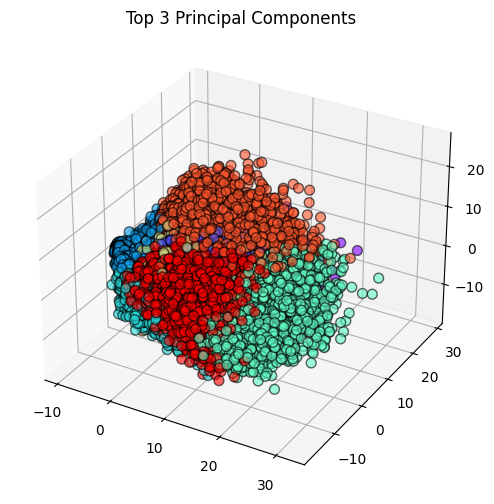

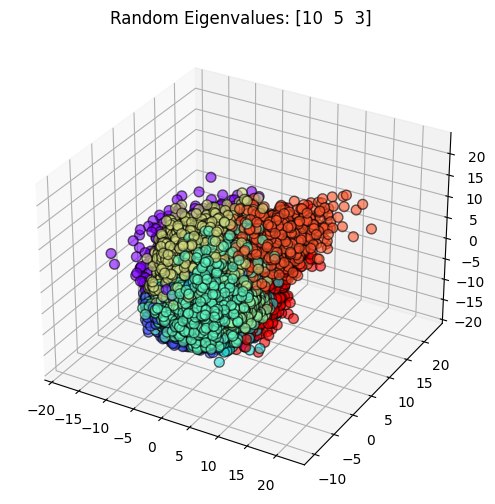

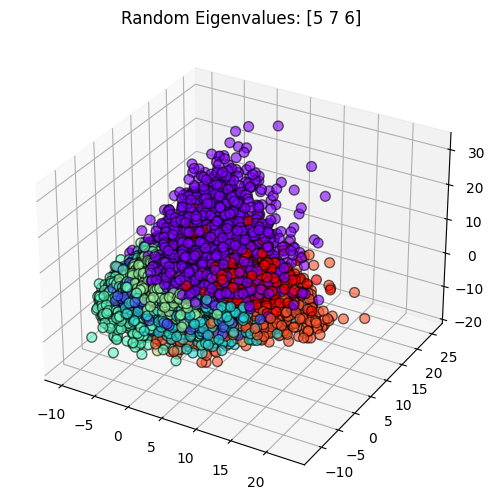

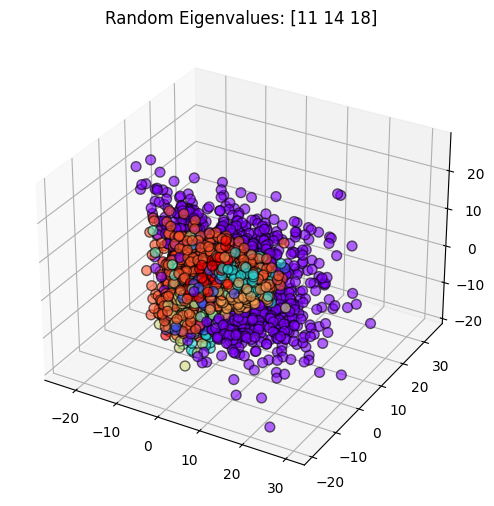

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# 1. Run KMeans on MNIST data.
kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(mnist_data)

# 2. Perform PCA on the same data.
pca = PCA(n_components=20) # We'll extract the top 20 components for future use
mnist_pca = pca.fit_transform(mnist_data)

# Helper function to plot 3D
def plot_3d(data, clusters, indices, title):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(data[:, indices[0]], data[:, indices[1]], data[:, indices[2]], 
                         c=clusters, cmap='rainbow', marker='o', edgecolor='k', s=50, alpha=0.6)
    ax.set_title(title)
    plt.show()

# 3. Visualize the data in 3D using PCA with the top 3 eigenvalues.
plot_3d(mnist_pca, clusters, [0, 1, 2], "Top 3 Principal Components")

# 4. Randomly select 3 eigenvalues from the top 20 and visualize them in 3D.
for _ in range(3): # Repeating 3 times
    random_indices = np.random.choice(range(20), 3, replace=False)
    plot_3d(mnist_pca, clusters, random_indices, f"Random Eigenvalues: {random_indices}")



### PROBLEM 5 : Implement Kernel PCA for linear regression


In [19]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import KernelPCA

# 1. Load the datasets
two_spirals = pd.read_csv('twoSpirals.txt', sep='\t', header=None)
three_circles = pd.read_csv('threecircles.txt', sep=',', header=None)

datasets = {
    "twoSpirals": two_spirals,
    "threeCircles": three_circles
}

for name, data in datasets.items():
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values

    # 2. Train a Linear Regression on the original data
    reg = LinearRegression().fit(X, y)
    predictions = reg.predict(X)
    mse = mean_squared_error(y, predictions)
    print(f"Original MSE for {name}: {mse:.3f}")

    # 3. Implement KernelPCA with Gaussian Kernel
    X2 = np.sum(X*X, axis=1).reshape(-1, 1)
    DIST_euclid = X2 + X2.T - 2 * np.dot(X, X.T)
    sigma = 3
    K = np.exp(-DIST_euclid/sigma)
    N = K.shape[0]
    U = np.ones((N, N)) / N
    Kn = K - np.dot(U, K) - np.dot(K, U) + np.dot(U, np.dot(K, U))

    eigenvalues, eigenvectors = np.linalg.eigh(Kn)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]
    eigenvalues = eigenvalues[sorted_indices]

    # 4. Retrain Linear regression on the transformed D-dim data
    for D in [3, 20, 100]:
        X_transformed = np.dot(Kn, eigenvectors[:, :D])
        reg_transformed = LinearRegression().fit(X_transformed, y)
        predictions_transformed = reg_transformed.predict(X_transformed)
        mse_transformed = mean_squared_error(y, predictions_transformed)
        print(f"MSE for {name} with D={D}: {mse_transformed:.3f}")



Original MSE for twoSpirals: 0.839
MSE for twoSpirals with D=3: 0.838
MSE for twoSpirals with D=20: 0.181
MSE for twoSpirals with D=100: 0.008
Original MSE for threeCircles: 0.666
MSE for threeCircles with D=3: 0.030
MSE for threeCircles with D=20: 0.005
MSE for threeCircles with D=100: 0.000
